<a href="https://colab.research.google.com/github/LoreJob/DeepFake-Dct/blob/main/CNN_for_DeepFake_Detection_in_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CNN for DeepFake Detection


# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Ram/Disk on the upper-left part of the colab → Additional Connection Options
- select GPU T4 from the Hardware Accelerator drop-down (You have just 1 hour of using)

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
7.214328854999998
GPU (s):
0.10292108700001279
GPU speedup over CPU: 70x


In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## Importing the directory from GitHub


In [ ]:
!git clone https://github.com/LoreJob/DeepFake-Dct.git

Cloning into 'DeepFake-Dct'...
remote: Enumerating objects: 173375, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 173375 (delta 54), reused 145 (delta 46), pack-reused 173214
Receiving objects: 100% (173375/173375), 1.55 GiB | 25.94 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (380678/380678), done.


## Packages
As the title says, we are using the tensorflow package.

In [ ]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

## Importing the dataset
The dataset contains 3 folders:
1. Train, with 140k images divided 50% in Real and Fake;
2. Validation, with 39k images divided 50% in Real and Fake;
3. Test, with 10k images divided 50% in Real and Fake.

Our images are 256x256 pixels.


In [ ]:
data_dir = "/content/DeepFake-Dct/dataset big"

In [ ]:
os.listdir(data_dir)

['Test', 'Train', 'Validation']

In [ ]:
print(len( os.listdir((os.path.join(data_dir,'Train','Real')))))
print(len( os.listdir((os.path.join(data_dir,'Train','Fake')))))

70001
70001


In [ ]:
for image_class in os.listdir((os.path.join(data_dir,'Train','Real'))):
  print(image_class)
  break

real_14275.jpg


In [ ]:
img = cv2.imread(os.path.join(data_dir,'Train','Real','real_0.jpg'))

In [ ]:
type(img)

numpy.ndarray

In [ ]:
img.shape

(256, 256, 3)

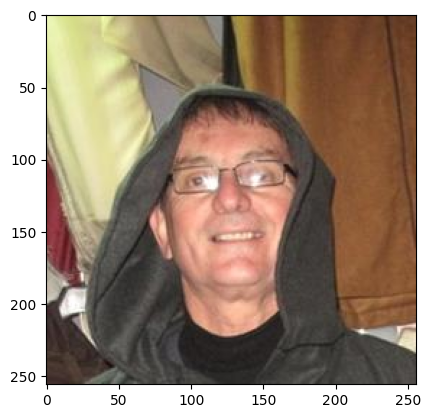

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### Create the train and validation

In [ ]:
data_direct = "/content/DeepFake-Dct/dataset big/Train"
train_data = tf.keras.utils.image_dataset_from_directory(data_direct)

data_iterator = train_data.as_numpy_iterator()

batch = data_iterator.next()

print(len(batch))

Found 140002 files belonging to 2 classes.
2


In [ ]:
batch[0].shape

(32, 256, 256, 3)

In [ ]:
batch[1]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

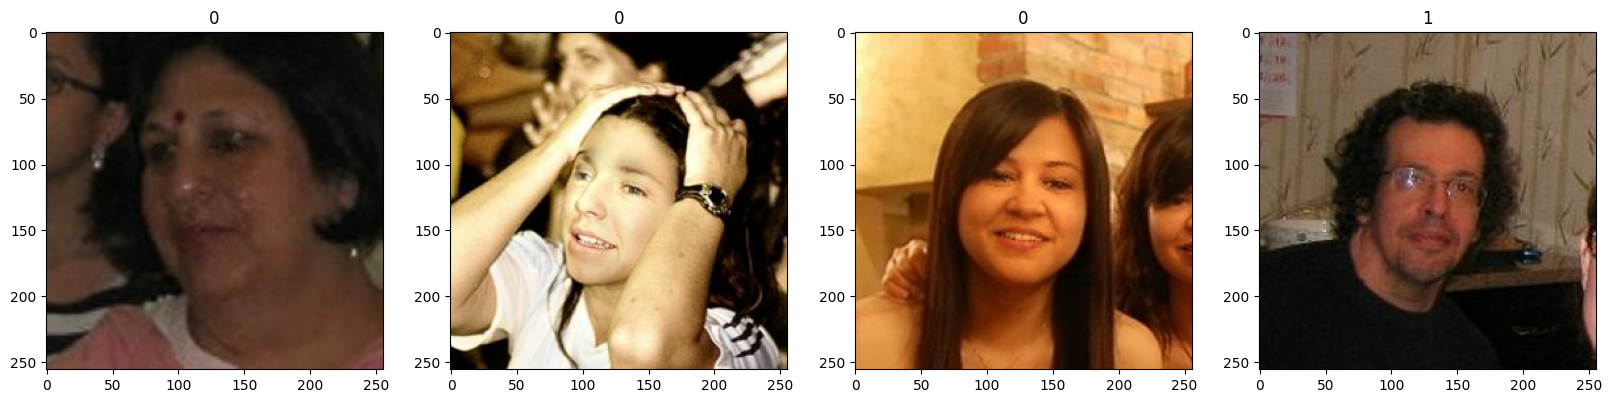

In [ ]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_direct,
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

Found 140002 files belonging to 2 classes.


In [ ]:
val_data = tf.keras.utils.image_dataset_from_directory(
    "/content/DeepFake-Dct/dataset big/Validation",
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

Found 39428 files belonging to 2 classes.


## Creating the model

We are using a CNN with 21 layers divided in:
- 1 Rescaling for data processing;
- 5 layers for data agumentation;
and the CNN with:
- 4 Conv2D with ReLu function, progressive;
- 4 MaxPooling
- 4 Dropout (3 of 10% and the last one of 25%);
- 2 Dense (1 ReLu an the last one Sigmoid);
- 1 Flatten


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.prefetch(buffer_size=AUTOTUNE)
val_data = val_data.prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = models.Sequential([
    # Preprocessing
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    # Data Augmentation
    # layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.2, fill_mode = "nearest"),
    # layers.RandomZoom(0.2),
    # layers.RandomContrast(0.2),
    # layers.RandomTranslation(0.2, 0.2),

    # CNN

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Dropout layer with 10% rate

    layers.Conv2D(256, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),

    layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.25), # Dropout layer with 25% rate
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_26 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_27 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_epoch_{epoch:02d}.h5',
    save_best_only=False,
    save_weights_only=False,
    save_freq='epoch')


early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/10
4376/4376 [==============================] - 587s 134ms/step - loss: 0.5364 - accuracy: 0.8185 - val_loss: 0.4379 - val_accuracy: 0.8498
Epoch 2/10
4376/4376 [==============================] - 592s 135ms/step - loss: 0.3244 - accuracy: 0.9088 - val_loss: 0.3674 - val_accuracy: 0.8853
Epoch 3/10
4376/4376 [==============================] - 589s 135ms/step - loss: 0.2660 - accuracy: 0.9322 - val_loss: 0.2996 - val_accuracy: 0.9145
Epoch 4/10
4376/4376 [==============================] - 593s 136ms/step - loss: 0.2377 - accuracy: 0.9421 - val_loss: 0.2834 - val_accuracy: 0.9196
Epoch 5/10
4376/4376 [==============================] - 592s 135ms/step - loss: 0.2223 - accuracy: 0.9465 - val_loss: 0.2684 - val_accuracy: 0.9242
Epoch 6/10
4376/4376 [==============================] - 600s 137ms/step - loss: 0.2100 - accuracy: 0.9505 - val_loss: 0.2594 - val_accuracy: 0.9272
Epoch 7/10
2752/4376 [=================>............] - ETA: 3:26 - loss: 0.2029 - accuracy: 0.9522

### Testing the model

In [ ]:
test_data = tf.keras.utils.image_dataset_from_directory(
    "/content/DeepFake-Dct/dataset big/Test",
    image_size=(256, 256),
    batch_size=32,
    seed=123
)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
test_data = test_data.prefetch(buffer_size=AUTOTUNE)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_data)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")